### Introduction

By the year 2912, interstellar voyages have become a commonplace component of human civilization, presenting unique challenges and opportunities for the field of advanced data science. It was against this backdrop that a critical situation emerged involving the Spaceship Titanic, a pioneering interstellar passenger vessel. Launched just a month prior, this vessel was transporting approximately 13,000 individuals to start anew on one of three terraformed exoplanets within the neighboring stellar systems.

Unfortunately, the journey was marred by a catastrophic event as the vessel neared Alpha Centauri, heading towards the temperate exoplanet 55 Cancri E. The Spaceship Titanic encountered an undetected spacetime anomaly hidden within an interstellar dust cloud. Echoing the tragic fate of its namesake from a millennium ago, the vessel remained structurally intact, yet a significant portion of its passengers were instantaneously transported to an alternate dimension [1].

### The Challenge

To analyze the datasets recovered from the ship's compromised data systems to ascertain which passengers were affected by the anomaly and thus displaced from their original dimension. The successful identification of these individuals is imperative for the coordination of a rescue operation and holds the potential to prevent a disaster of historical magnitude.
The goal is to unlock the solution to this cosmic enigma, offering relief and hope to the myriad lives in anticipation of news regarding their displaced kin.


#### Reference
https://www.kaggle.com/competitions/spaceship-titanic/overview

In [22]:
# Begin by importing all required libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn import datasets
import seaborn as sns
from itertools import combinations
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# Define plot settings
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["figure.figsize"] = (20,10)

### Dataset explanation

- **`PassengerId`**: A unique Id for each passenger, formatted as ***gggg_pp*** where ***gggg*** indicates a group the passenger is traveling with, and ***pp*** is their number within the group. People in a group are often family members, but not always.

- **`HomePlanet`**: The planet the passenger departed from, typically their planet of permanent residence.

- **`CryoSleep`**: Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- **`Cabin`**: The cabin number where the passenger is staying, formatted as ***deck/num/side***, where ***side*** can be either ***P*** for Port or ***S*** for Starboard.

- **`Destination`**: The planet the passenger will be debarking to.

- **`Age`**: The age of the passenger.

- **`VIP`**: Whether the passenger has paid for special VIP service during the voyage.

- **`RoomService`, `FoodCourt`, `ShoppingMall`, `Spa`, `VRDeck`**: The amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- **`Name`**: The first and last names of the passenger.

- **`Transported`**: Whether the passenger was transported to another dimension. This is the target column for prediction.


## 1. Data Analysis
### First, identify missing values in the data

In [23]:
# Read data
train_df = pd.read_csv('csv_files/train.csv')

# Preview data
print('Raw data format:')
display(train_df.head())

# Determining the amount of missing data per column
missing_data = train_df.isna().sum()

# Calculating the percentage of missing data per column
missing_percentage = (missing_data / len(train_df)) * 100

missing_info = pd.DataFrame({
    "Missing Values": missing_data,
    "Percentage": missing_percentage
})

missing_info.sort_values(by="Missing Values", ascending=False)

Raw data format:


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


,Missing Values,Percentage
CryoSleep,217,2.496261
ShoppingMall,208,2.392730
VIP,203,2.335212
HomePlanet,201,2.312205
Name,200,2.300702
Cabin,199,2.289198
VRDeck,188,2.162660
FoodCourt,183,2.105142
Spa,183,2.105142
Destination,182,2.093639


`PassengerId` and `Transported` have no missing values. The missingness pattern suggests that the data might be Missing Completely at Random (MCAR) or Missing at Random (MAR), as the percentages are relatively low and distributed across various features without an apparent pattern. However, further analysis would be required to ascertain the missingness mechanism fully, especially considering the potential relationships between features (e.g., passengers from a specific HomePlanet might have more missing data in certain amenities due to cultural preferences or socioeconomic factors). Subsequent sections on data analysis aim to identify potential relationships between features.
>Reference : Mack C, Su Z, Westreich D. Managing Missing Data in Patient Registries: Addendum to Registries for Evaluating Patient Outcomes: A User’s Guide, Third Edition [Internet]. Rockville (MD): Agency for Healthcare Research and Quality (US); 2018 Feb. Types of Missing Data. Available from: https://www.ncbi.nlm.nih.gov/books/NBK493614/

## 1.1 Target Variable Analysis 

In [24]:
# Since 'Transported' is bool, just use direct sum
transported_true_percentage = (train_df['Transported'].sum() / len(train_df['Transported'])) * 100

transported_false_percentage = 100 - transported_true_percentage

print('Percentage of travellers transported: {:.2f}%'.format(transported_true_percentage))
print('Percentage of travellers NOT transported: {:.2f}%'.format(transported_false_percentage))

Percentage of travellers transported: 50.36%
Percentage of travellers NOT transported: 49.64%


**Inference:**
> The distribution of the target variable is approximately equal, showing that about half of the people on the ship were mysteriously transported. This shows us that the data is indeed balanced, so accuracy is a good metric.

## 1.2 Visualisation of Continous Features 
Having an idea of the distribution of the continous features in the dataframe will give us an idea of the skew present in the data.

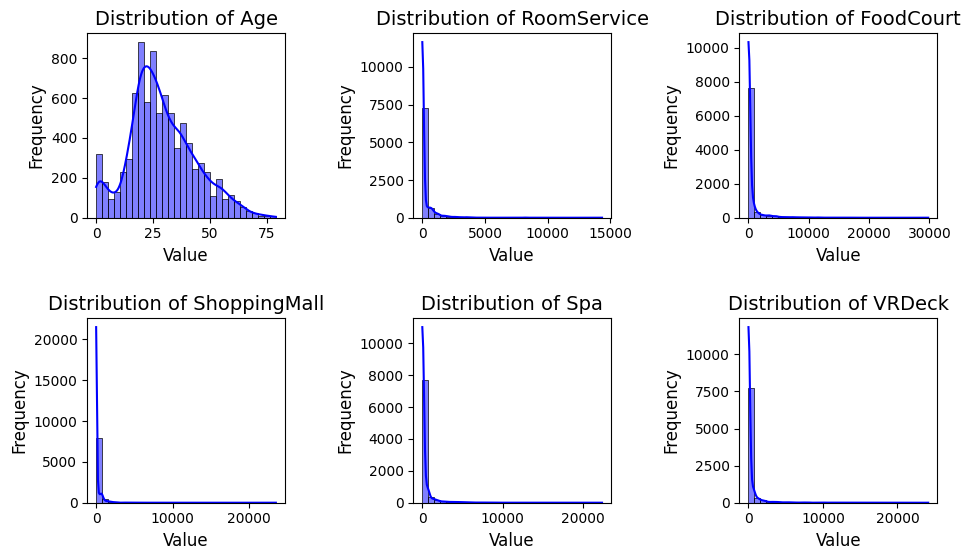

In [25]:
# Identify continuous columns
cont_cols = [f for f in train_df.columns if train_df[f].dtype in [np.float64, np.int64] and train_df[f].nunique() > 20]

# Calculate the number of rows needed for the subplots
n_rows = np.ceil(len(cont_cols) / 3).astype(int)

# Create subplots with 3 columns and the necessary number of rows
fig, axs = plt.subplots(n_rows, 3, figsize=(10, 3 * n_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, col in enumerate(cont_cols):
    sns.histplot(train_df[col], ax=axs[i], kde=True, color='blue', bins=30)
    axs[i].set_title(f'Distribution of {col}', fontsize=14)
    axs[i].set_xlabel('Value', fontsize=12)
    axs[i].set_ylabel('Frequency', fontsize=12)
    axs[i].tick_params(axis='both', which='major', labelsize=10)


plt.tight_layout()
plt.show()

>From the above distributions we see that all the features are heavily skewed to the right, with only the age being slighly less skewed, with most of the people on board in the age range of 20-30 years old.

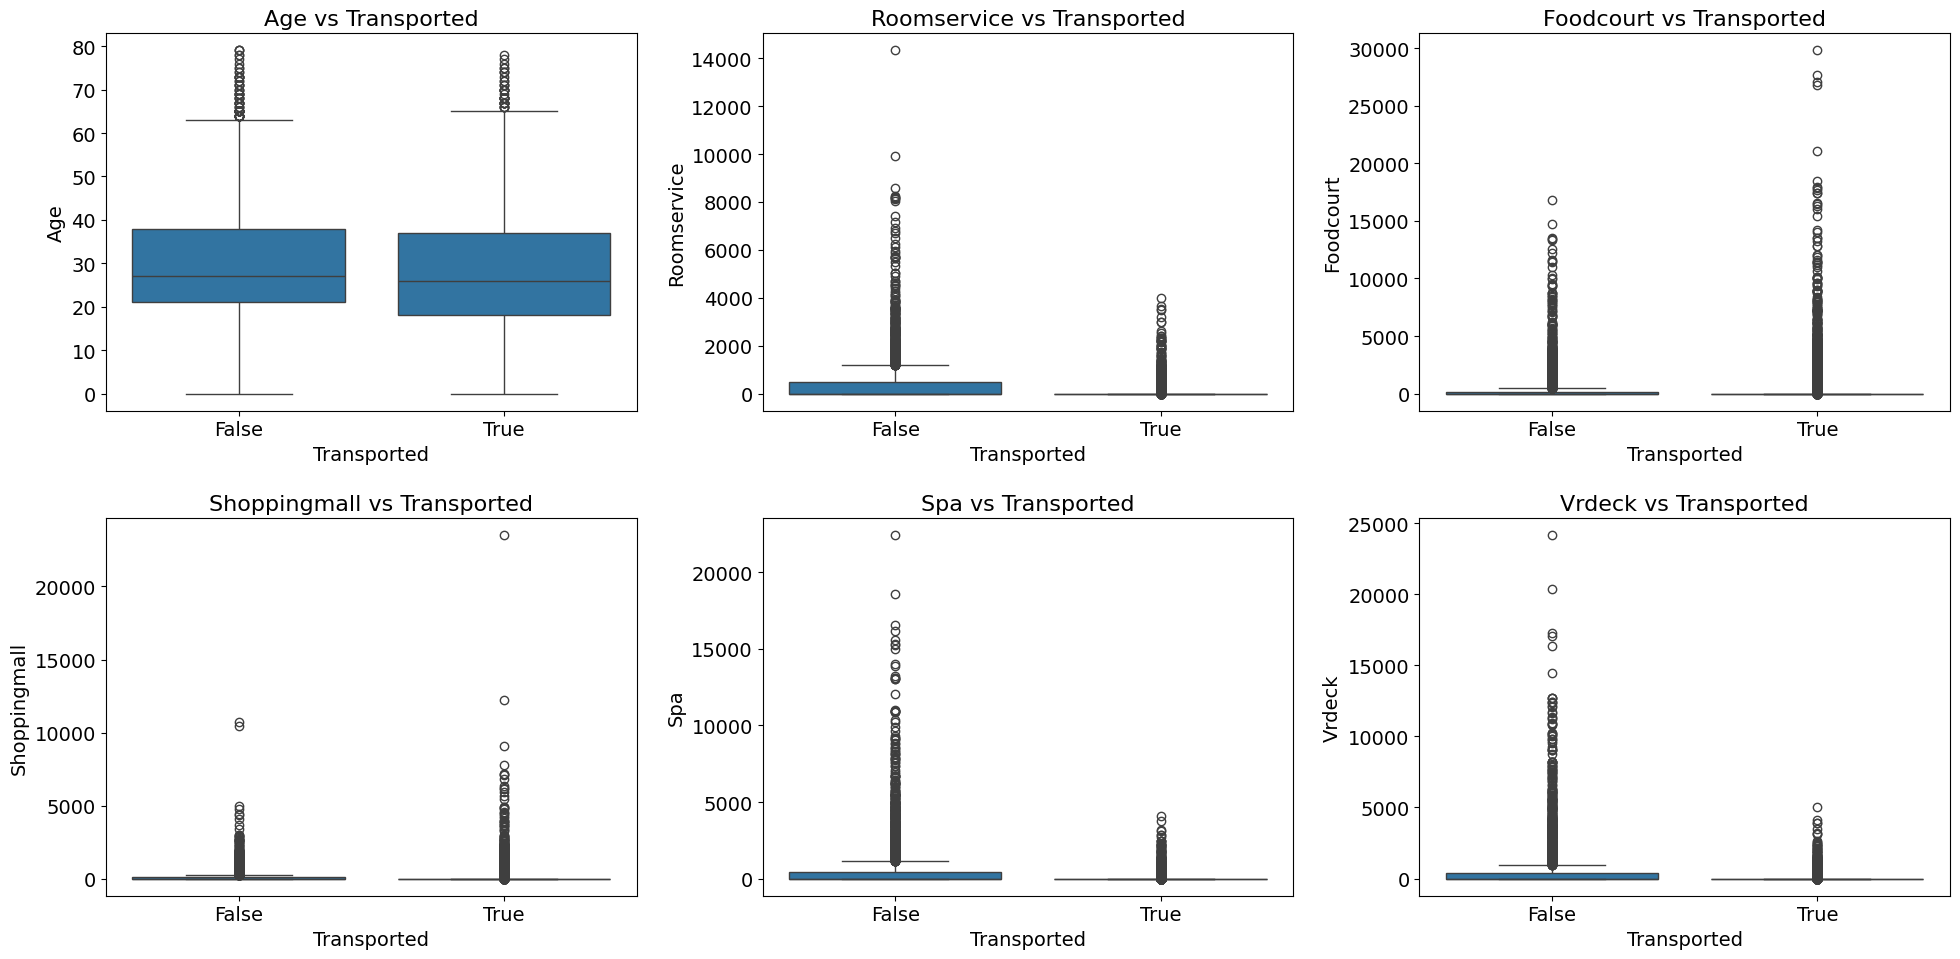

In [26]:
# Create subplots with 3 columns per row
fig, axs = plt.subplots(n_rows, 3, figsize=(20, 5 * n_rows))

# Flatten the axs array for easy iteration
axs = axs.flatten()

for i, col in enumerate(cont_cols):
    sns.boxplot(x='Transported', y=col, data=train_df, ax=axs[i])
    axs[i].set_title(f'{col.title()} vs Transported', fontsize=16)
    axs[i].set_xlabel('Transported', fontsize=14)
    axs[i].set_ylabel(col.title(), fontsize=14)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

#### Insights From the Box Plots :

1. **Age vs Transported**: The distribution of ages is relatively similar for both transported and not transported passengers. This indicates that age may not be a strong differentiator in predicting whether a passenger was transported or not.

2. **Roomservice vs Transported**: For the 'Roomservice' expenditure, there's a noticeable trend where passengers who were not transported have more outliers on the higher end of spending, which suggests that passengers who spent more on room service were less likely to be transported.

3. **Foodcourt vs Transported**: A similar trend is observed with the 'Foodcourt' spending as with 'Roomservice',except with an inverse correlation. Those who were transported have more outliers on the extreme end of spending. From a practical perspective (although the data is inherently fictious), this suggests that those who spent more on roomservice probably spent less in the food court - indicating that these two features may be linked. 

4. **Shoppingmall vs Transported**: 'Shoppingmall' spending shows a similar distribution across both categories, with not many outliers and the medians close to zero, however there are more outliers with 'true' compared to false.

5. **Spa vs Transported**: Expenditure on the spa seems to follow the same pattern as 'Roomservice'  where passengers who were not transported show a trend of higher spending, as evidenced by more significant outliers.

6. **VR Deck vs Transported**: Spending on the VR Deck is again similar to the pattern observed in 'Roomservice',  and 'Spa', with those not transported showing higher spending.

#### Implications of the distributions

1. **Outliers** There are significant outliers in the expenditure categories, neccesitating a careful approach to dealing with these features as the outliers may decrease the performance of the machine learning algorithm. 
2. **Feature Importance** Not all features appear to have a strong correlation with being transported or not, for example age seems not to be a factor that plays a role. 
3. **Feature Engineering** Features which have similar distributions such as the expenditure related features, could be grouped together to represent the overall spending habits of an individual. 



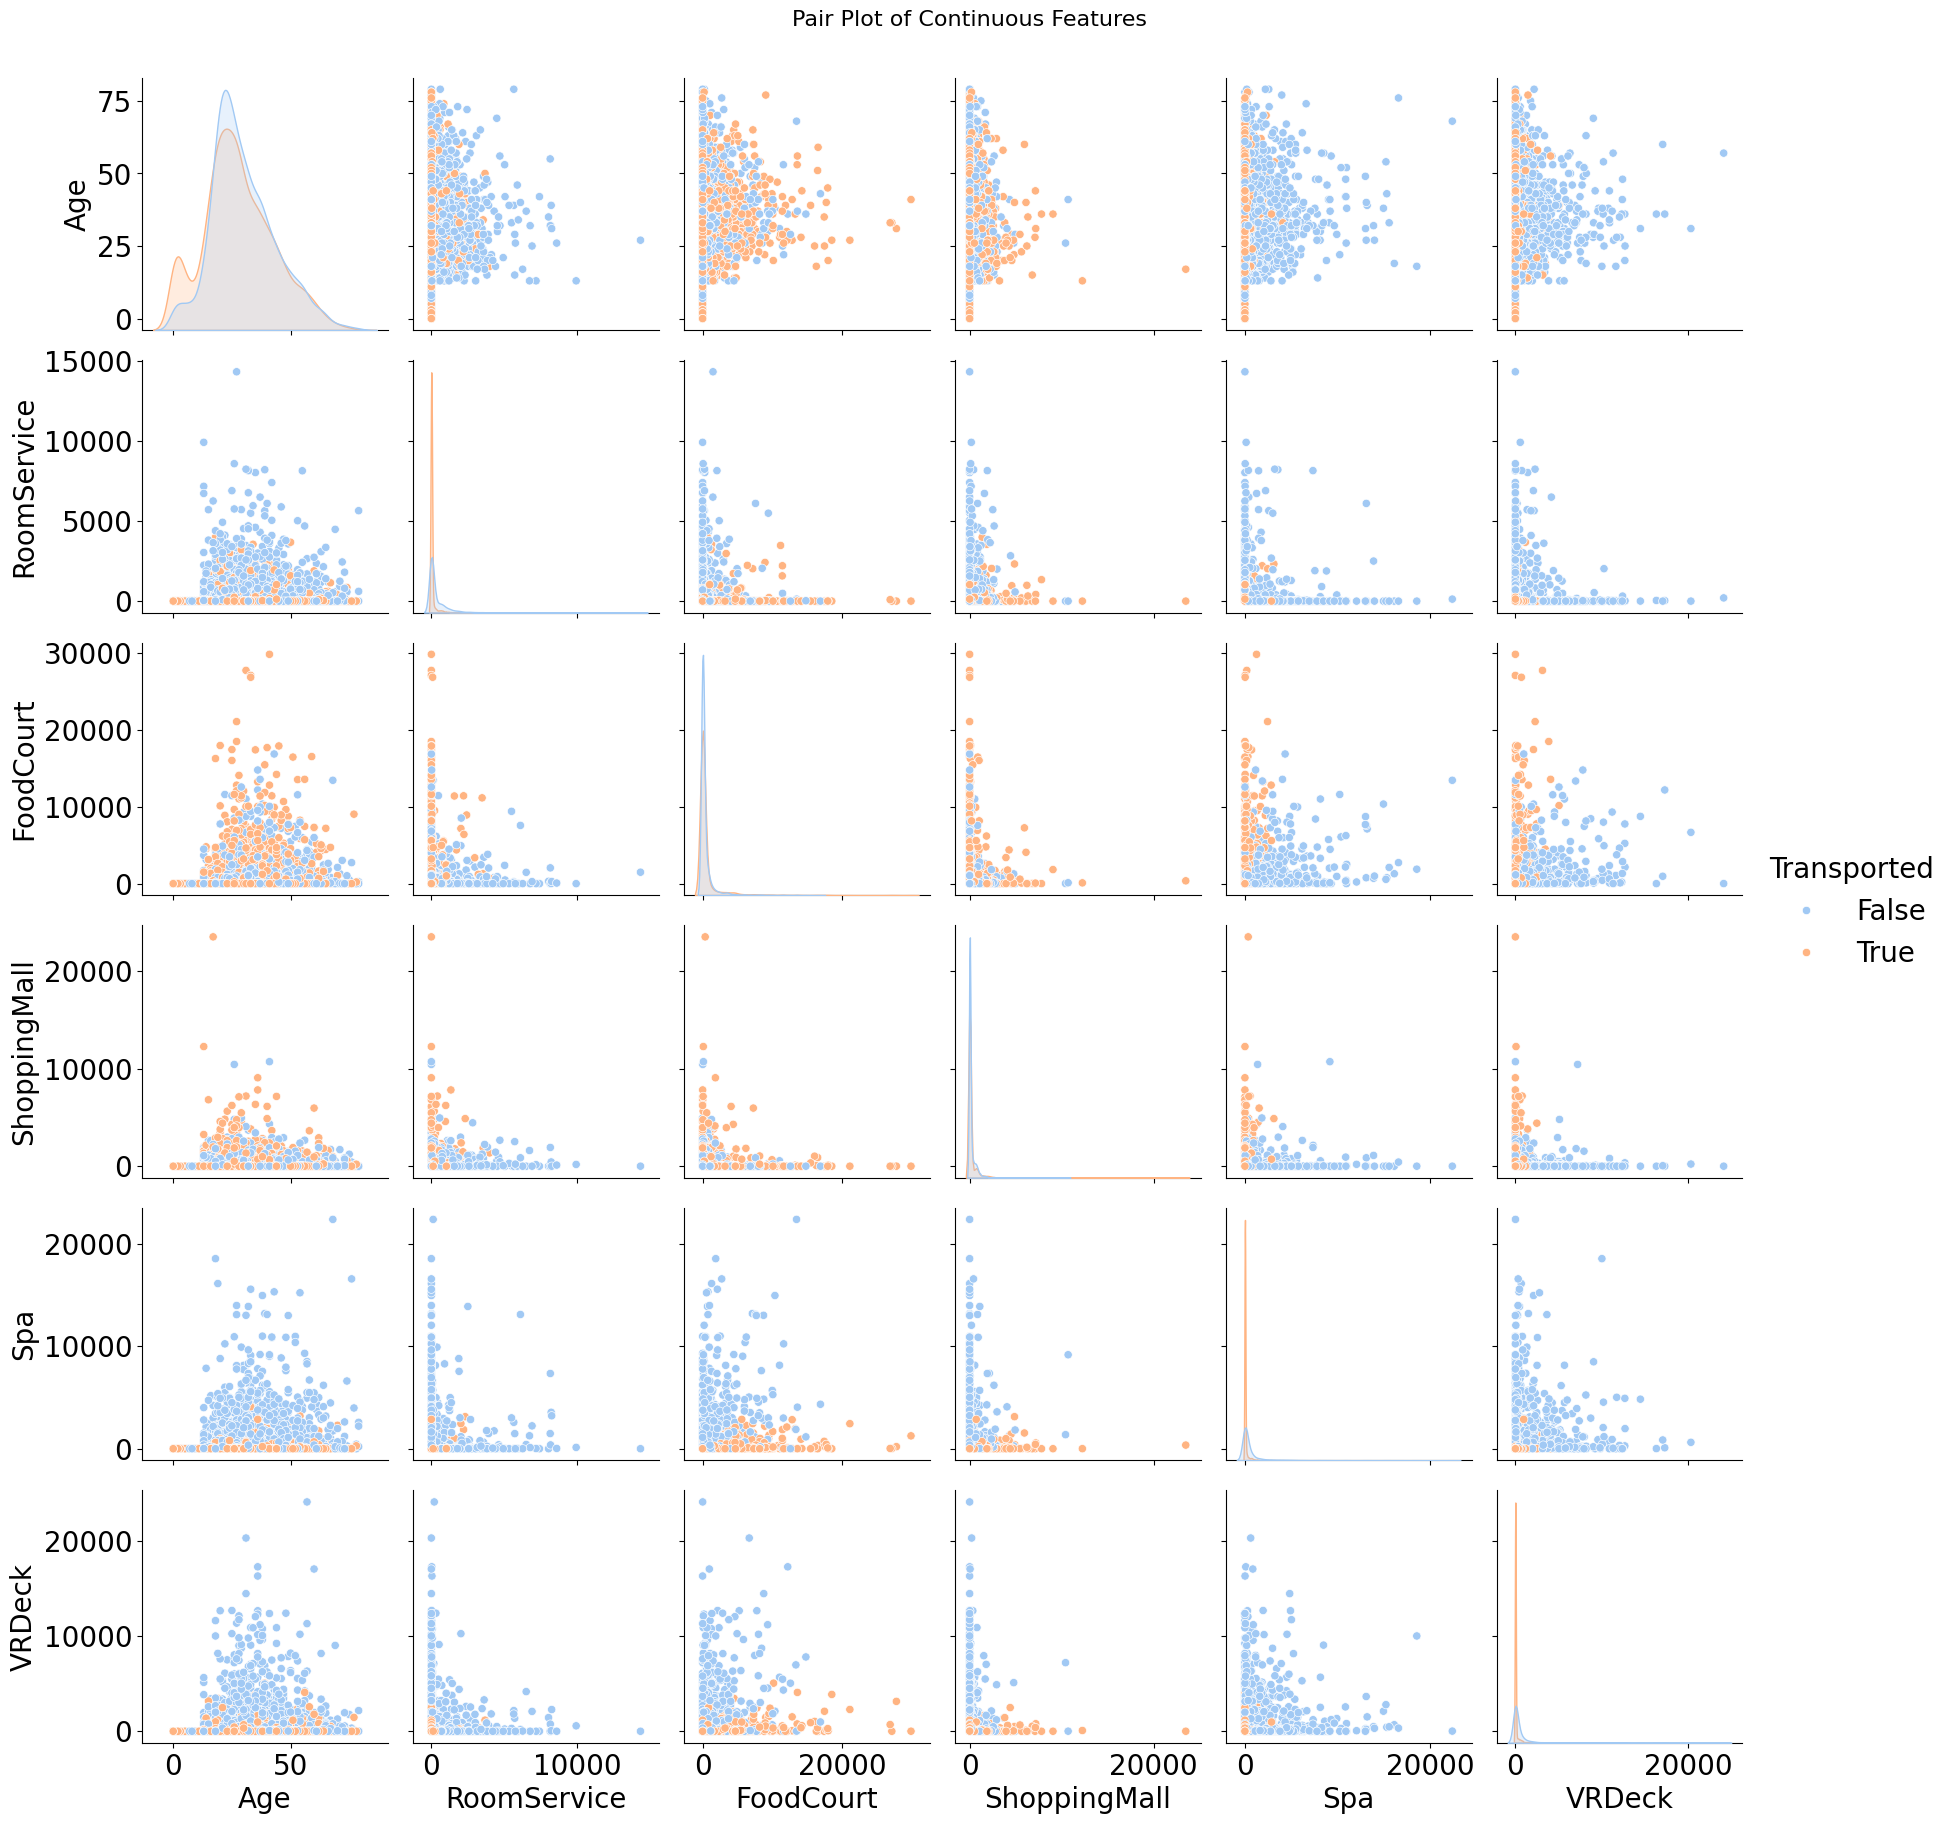

In [27]:
sns.pairplot(data=train_df, vars=cont_cols, hue='Transported', palette='pastel', height=3)
plt.suptitle('Pair Plot of Continuous Features', size=16, y=1.02)
plt.show()


#### Insights From the Pairwise Plots

1. **Diagonal (Distribution of Each Variable)**: 
   - Age: The distribution of age is fairly normal but with a slight right skew, however it is noticeable that younger ages have a higher number of transported cases. To see this more clearly, a plot of the age distribution is shown below. 
   - RoomService, FoodCourt, ShoppingMall, Spa, VRDeck: All these features have distributions that are heavily right-skewed, indicating that a majority of passengers spend little to no money on these services, with a few spending a lot.

2. **Non-Diagonal (Relationship Between Variables)**:
   - There do not appear to be strong linear relationships between any two given features; this is characterized by the lack of discernible trends or patterns in the scatter plots.
   - Most scatter plots exhibit clustering at the lower end of the expenditure features, suggesting that the majority of data points have low spending values across these services.
   - The points are colored by whether the individual was transported or not, but there does not seem to be a clear separation between the two classes based on these features alone, implying that a simple linear model might struggle to distinguish between the classes based on these features alone.
   - There are several outliers, particularly in the expenditure features, which could be influential points for certain types of models. These might need to be examined further to determine if they should be kept, scaled, or handled in another manner.


Text(0.5, 0, 'Age (years)')

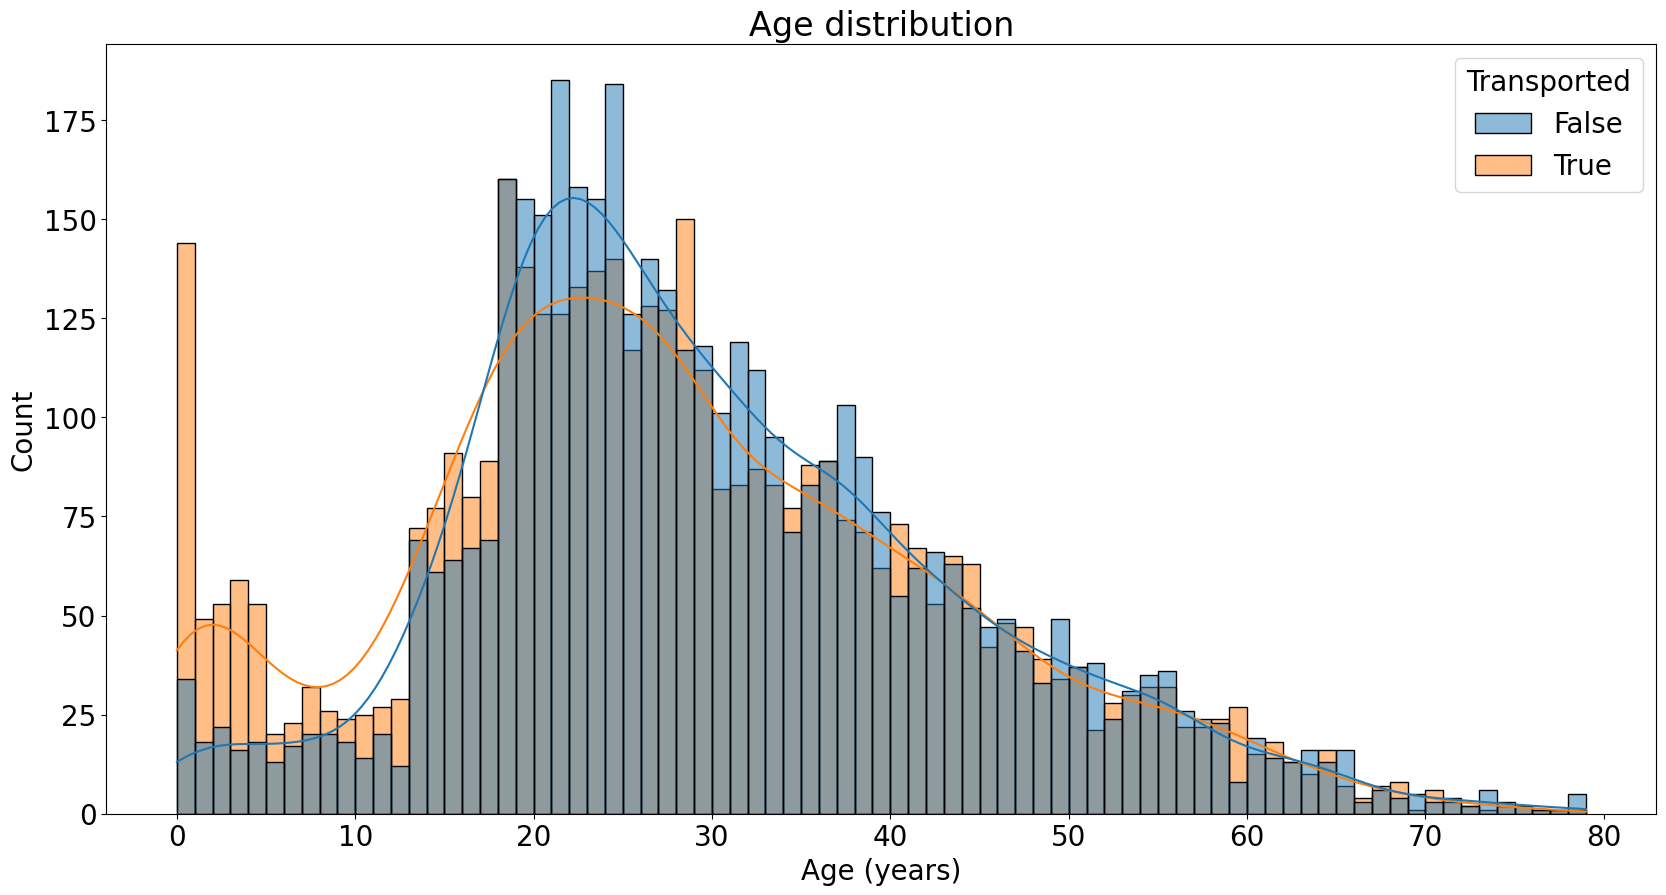

In [28]:
# Histogram
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

By reviewing the age plot in greater detail, some patterns emerge : 
- **0-18 year olds**: more likely to be transported.
- **18-25 year olds**: less likely to be transported.
- **Over 25 year olds**: equally likely to be transported.


This suggests that perhaps a new feature categorising passengers as child, adolescent, or adult based on age may improve model accuracy. 

## 1.3 Strategies for Missing Values 

1. **Age**: Given its distribution and lack of strong differentiation power for the target variable, imputing missing values with the median age might be a prudent choice to maintain the distribution's shape.

2. **Expenditure Features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)**: These features exhibit right-skewness and contain significant outliers, suggesting that imputation methods that preserve these characteristics, such as median imputation or even more sophisticated methods like KNN or iterative imputation, might be appropriate. Considering the presence of outliers, median imputation could be more robust than mean imputation.

3. **Categorical Features (HomePlanet, CryoSleep, Destination, VIP)**: For missing categorical data, mode imputation (replacing missing values with the most frequent category) could be a straightforward and effective approach.

4. **Outliers and Feature Engineering**: Given the insights on outliers and spending habits, we might consider creating new features that summarize overall spending or capture spending behavior patterns. Additionally, treating or capping outliers before model training could improve model robustness.

5. **Missing Flags**: For features with a significant amount of missing data, consider creating binary "missing flag" features that indicate whether a data point was originally missing. This can sometimes capture additional information that the missingness itself provides.

Before we delve into an alternative method to the pairwise plots, we leverage *SKlearn's* imputer to impute the numerical columns with the median and the categorical columns. After this we note that there are still missing values in the name and cabin columns, which we will deal with at a later stage if neccesary. 

In [29]:
# Imputers
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# List of numerical and categorical columns that need imputation
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Imputation
train_df[numerical_cols] = median_imputer.fit_transform(train_df[numerical_cols])
train_df[categorical_cols] = mode_imputer.fit_transform(train_df[categorical_cols])

# Verify the imputation by checking for missing values again
missing_data_after = train_df.isna().sum()

missing_data_after

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            200
Transported       0
dtype: int64

## 2.1.1  Support Vector Machines (SVM)

In this section, we delve into an alternative method for feature analysis and predictive modeling using Support Vector Machines (SVM). SVM is a powerful supervised learning algorithm capable of both classification and regression tasks. Its primary objective is to find the optimal hyperplane that best separates classes in a high-dimensional space.[1]

#### Understanding SVM:
SVM operates by mapping input data points to a high-dimensional feature space, where it seeks to find the hyperplane that maximizes the margin between classes. This hyperplane is determined by support vectors, which are data points closest to the decision boundary. SVM can handle both linear and non-linear classification through the use of different kernel functions, such as linear, polynomial, radial basis function (RBF), or sigmoid.

>Reference: [1] “1.4. Support Vector Machines,” scikit-learn, 2024. https://scikit-learn.org/stable/modules/svm.html (accessed Mar. 12, 2024).
‌
The python code below  demonstrates the application of SVM for feature analysis and predictive modeling. It iterates over all possible pairs of continuous features, trains an SVC model for each pair, and evaluates their accuracy in predicting the target variable, 'Transported'.

By analyzing the accuracy of different feature pairs, this approach provides valuable insights into the predictive power of various combinations of continuous features concerning the 'Transported' variable. This information can guide further feature selection and engineering strategies to enhance model performance.

In [42]:
# Convert 'Transported' to integer (True=1, False=0) for modeling
train_df['Transported'] = train_df['Transported'].astype(int)

# Generate all possible pairs of the continuous columns
feature_pairs = list(combinations(cont_cols, 2))

# Initialize a PrettyTable to display the results
table = PrettyTable()
table.field_names = ['Feature Pair', 'Accuracy']

# Initialize a list to store results for sorting
results = []

# Loop over each pair, train a model, and evaluate the accuracy
for pair in feature_pairs:
    # Extract the features for the current pair
    X_pair = train_df[list(pair)]
    
    # Target variable
    y = train_df['Transported']
    
    # Train a Support Vector Classifier
    model = SVC(gamma='auto')
    model.fit(X_pair, y)
    
    # Predict and calculate accuracy
    y_pred = model.predict(X_pair)
    acc = accuracy_score(y, y_pred)
    
    # Add the results to the list for sorting
    results.append((pair, acc))

# Sort the results by accuracy in descending order
results.sort(key=lambda x: x[1], reverse=True)

# Add the sorted results to the table
for pair, acc in results:
    table.add_row([pair, acc])

# Print the sorted table
print(table)

+---------------------------------+--------------------+
|           Feature Pair          |      Accuracy      |
+---------------------------------+--------------------+
|   ('RoomService', 'FoodCourt')  | 0.8126078453928448 |
|  ('FoodCourt', 'ShoppingMall')  | 0.8109973541930289 |
|      ('RoomService', 'Spa')     | 0.8057057402507765 |
|    ('RoomService', 'VRDeck')    | 0.8031749683653514 |
|     ('ShoppingMall', 'Spa')     | 0.7975382491659956 |
|       ('FoodCourt', 'Spa')      | 0.7942022316806626 |
|    ('ShoppingMall', 'VRDeck')   | 0.7940871965949614 |
|        ('Spa', 'VRDeck')        | 0.7913263545381342 |
|     ('FoodCourt', 'VRDeck')     | 0.7832738985390544 |
| ('RoomService', 'ShoppingMall') | 0.7772920740825952 |
|          ('Age', 'Spa')         | 0.7334637064304613 |
|      ('Age', 'RoomService')     | 0.725756355688485  |
|        ('Age', 'VRDeck')        | 0.7244909697457724 |
|       ('Age', 'FoodCourt')      | 0.7186241803750144 |
|     ('Age', 'ShoppingMall')  

The analysis reveals that the SVM-based method provides more reliable insights compared to visualization alone, as it quantifies the predictive power of feature pairs with accuracy scores. Specifically, the combination of FoodCourt and RoomService demonstrates strong classification ability. Given that all top features in the table are expenditure-related, it's inferred that aggregating all expenditure features into a combined total expenditure could yield a more effective feature for classification. This understanding emphasizes the importance of feature engineering in maximizing predictive performance based on data insights.

## 2.1.2 Feature Engineering 

In [44]:
expenditure_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_df['TotalExpenditure'] = train_df[expenditure_features].sum(axis=1)
features = expenditure_features + ['TotalExpenditure', 'Age']
X = train_df[features]
y = train_df['Transported']
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Cross-validation setup
cv = StratifiedKFold(n_splits=5)  # Using 5 folds
accuracies = []

# Testing different C values
C_values = [0.1, 1, 10]

for C_val in C_values:
    fold_accuracies = []
    for train_index, test_index in cv.split(X_imputed, y):
        X_train, X_test = X_imputed[train_index], X_imputed[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = SVC(gamma='auto', C=C_val)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fold_accuracies.append(accuracy_score(y_test, y_pred))
    mean_accuracy = np.mean(fold_accuracies)
    accuracies.append((C_val, mean_accuracy))

# Displaying the results
table = PrettyTable()
table.field_names = ['C Value', 'Average Accuracy (Unoptimised)']

for C_val, accuracy in accuracies:
    table.add_row([C_val, accuracy])

print(table)


+---------+--------------------------------+
| C Value | Average Accuracy (Unoptimised) |
+---------+--------------------------------+
|   0.1   |       0.7351927056209309       |
|    1    |       0.737148050775845        |
|    10   |       0.7371479846028729       |
+---------+--------------------------------+


We employ cross validation across varying c values to give us an idea of the accuracy, from this it is clear that a c value around 1 is optimal, however randomised search tuning will reveal more.

#### 2.1.3 Randomised Search Hyper Parameter Tuning

In [50]:
# Hyperparameter search space
param_distributions = {
    'C': reciprocal(0.5, 2),
    'gamma': expon(scale=0.01),
}

random_search = RandomizedSearchCV(SVC(), param_distributions, n_iter=50, cv=5, verbose=1, random_state=42, n_jobs=-1)
random_search.fit(X_imputed, y)
print("Best hyperparameters:", random_search.best_params_)

# Set and evaluate the optimized model
model_optimized = random_search.best_estimator_
scores_optimized = cross_val_score(model_optimized, X_imputed, y, cv=cv)
print(f"Optimized Model Accuracy: {scores_optimized.mean()} ± {scores_optimized.std()}")



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'C': 1.136682344899351, 'gamma': 0.0004756384975640855}
Optimized Model Accuracy: 0.7448552168455211 ± 0.011335744511379793


#### 2.1.4 Focusing A Grid Search Based on the Random Search

In [55]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define a focused hyperparameter grid based on random search results
param_grid = {
    'C': [1.1, 1.13, 1.15, 1.2],  # Values around 1.136
    'gamma': [0.0004, 0.00045, 0.000475, 0.0005, 0.00055],  # Values around 0.0004756
}

# Initialize the grid search on the model with parameters from random search
grid_search = GridSearchCV(SVC(), param_grid, cv=5, verbose=1, n_jobs=-1)
# Assuming X_imputed and y are your features and target variable respectively
grid_search.fit(X_imputed, y)

# Best parameters and accuracy from grid search
print("Best hyperparameters (Grid Search):", grid_search.best_params_)
print("Grid Search Optimized Model Accuracy:", grid_search.best_score_)
# Set the model with grid search optimized hyperparameters
model_optimizedwgrid = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


Best hyperparameters (Grid Search): {'C': 1.2, 'gamma': 0.0004}
Grid Search Optimized Model Accuracy: 0.7461202455546652
Accuracy with Interaction Features: 0.7370329098042536 ± 0.011675623306290555


In [52]:
# Load the test data
test_df = pd.read_csv('csv_files/test.csv')
# Imputers
median_imputer = SimpleImputer(strategy='median')
mode_imputer = SimpleImputer(strategy='most_frequent')

# List of numerical and categorical columns that need imputation
numerical_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

expenditure_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
test_df['TotalExpenditure'] = test_df[expenditure_features].sum(axis=1)
features = expenditure_features + ['TotalExpenditure', 'Age']  

# Select the same features as used for training the model for the test set
X_test = test_df[features]

# Note: No need to fit a new imputer. Use the existing imputer that was fitted on the training set
X_test_imputed = imputer.transform(X_test)  # Transform the test set features

# Predict using the trained SVM model
y_pred_test = model_optimizedwgrid.predict(X_test_imputed)

# Prepare the submission dataframe
submission_df = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Transported': y_pred_test
})

# Convert predictions back to boolean (True/False) if necessary
submission_df['Transported'] = submission_df['Transported'].astype(bool)

# Save the submission file
submission_df.to_csv('predictions_withrandomsandgrd.csv', index=False)
